<a href="https://colab.research.google.com/github/LudwigMeder/Time-Series-Prediction-of-the-NAO/blob/main/3_Model/NAO_with_EEMD_and_various_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization
Loading all necessary libraries and defining some functions:

In [1]:
!pip install EMD-signal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 985.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 766.5 kB/s eta 0:00:00


In [2]:
# load libraries:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from PyEMD import EEMD
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [3]:
def norm(data):
  """
  Args:
    data

  Returns: data normalized between [0,1]

  """
  max_value = data.max()
  min_value = data.min()

  norm_NAO = (data - min_value) / (max_value - min_value)
  return norm_NAO,max_value.values,min_value.values

def denorm(normalized_data,MAX,MIN):
  """
  Args:
    normalized_data
    MAX
    MIN

  Returns: data denormalized, reverses norm()

  """
  original_data = normalized_data*(MAX-MIN) + MIN
  return original_data

def perform_EEMD(index_data):
  """
  Performs EEMD following Wu et al. (2009), plots and returns the IMFs.
  Args:
    index_data

  Returns: all intrinsic mode functions, last one is the residual trend

  """
  # Initialize EEMD
  eemd = EEMD()

  # Perform EEMD
  IMFs = eemd.eemd(index_data.values)
  residual_trend = index_data.values-np.sum(IMFs,axis=0)
  IMFs = np.vstack((IMFs, residual_trend.reshape(1, -1)))
  # Plot the results
  num_IMFs = IMFs.shape[0]
  plt.figure(figsize=(20, 20))
  plt.subplot(num_IMFs + 2, 1, 1)
  plt.plot(index_data.values, 'r')
  plt.title("Original Time Series")
  for i in range(num_IMFs):
    plt.subplot(num_IMFs + 2, 1, i + 2)
    plt.plot(IMFs[i], 'g')
    plt.title(f"IMF {i + 1}")
  plt.tight_layout()

  return IMFs

def phase_check(y_test,y_pred):
  """

  Args:
    y_test
    y_pred

  Returns: phase agreement of the two time series in percentage

  """
  #check for phases in y_test and y_pred:
  y_test_phases = np.zeros(len(y_test))
  y_pred_phases = np.zeros(len(y_pred))
  negative_test = np.where(y_test <-1)[0]# currently everything between -1 and 1 is set to neutral (might have to rethink tis interval)
  negative_pred = np.where(y_pred <-1)[0]
  positive_test = np.where(y_test >1)[0]
  positive_pred = np.where(y_pred >1)[0]
  y_test_phases[negative_test] = -1
  y_pred_phases[negative_pred] = -1
  y_test_phases[positive_test] = 1
  y_pred_phases[positive_pred] = 1
  counter = np.sum(y_test_phases==y_pred_phases)
  phase_percent = 100/len(y_test) * counter
  return phase_percent

def MAPE(y_true, y_pred):
  """

  Args:
    y_true
    y_pred

  Returns: Mean Average Percentage Error

  """
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load the Data:

In [5]:
# load the data:
#monthly index:
NAO_monthly = pd.read_csv("https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_MONTHLY.csv")
NAO_monthly.set_index('Date', inplace=True)
#daily index:
NAO_daily = pd.read_csv("https://raw.githubusercontent.com/LudwigMeder/Time-Series-Prediction-of-the-NAO/main/1_DatasetCharacteristics/NAO_INDEX_DAILY.csv")
NAO_daily.set_index('date', inplace=True)

# Baseline Model - > ARIMA
Simple baseline to compare the more sophisticated arcitectures with.

In [ ]:
# Split the data into train and test sets to evaluate the model
train_size = int(len(NAO_monthly) * 0.98)
train, test = NAO_monthly[:train_size], NAO_monthly[train_size:]

(2000.0, 2024.0)

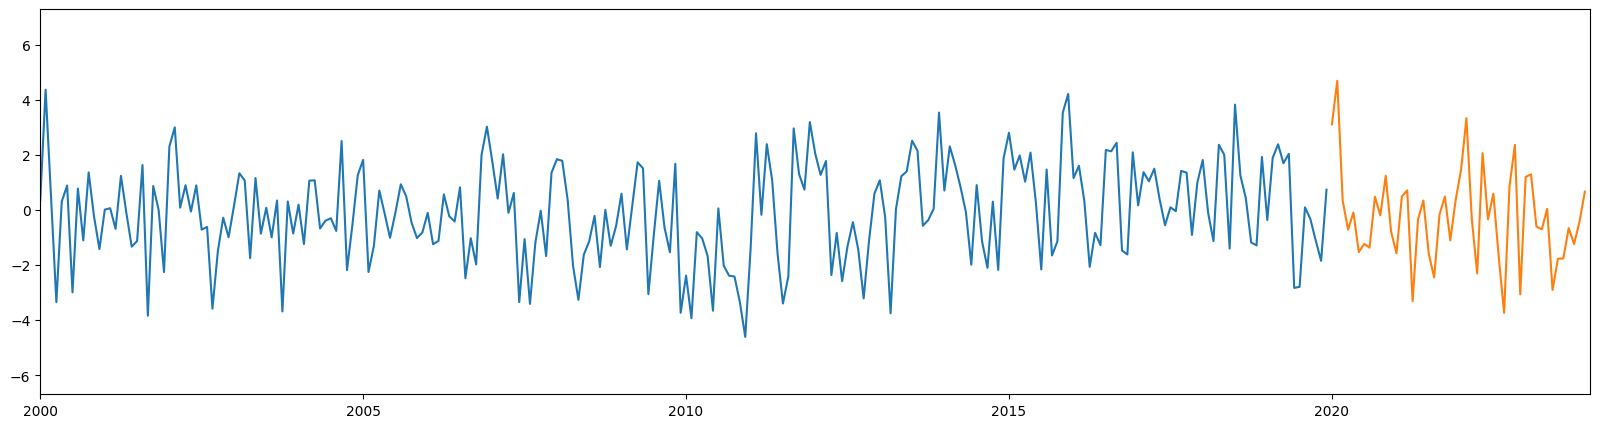

In [ ]:
plt.figure(figsize=[20,5])
plt.plot(np.arange(1825,2020,1/12),train.values)
plt.plot(np.arange(2020,2024,1/12),test.values)
plt.xlim(2000,2024)

In [ ]:
pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.2 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Find the best SARIMA parameters using auto_arima
stepwise_model = auto_arima(train, start_p=1, start_q=1,
                            max_p=5, max_q=5, m=12,
                            start_P=0, seasonal=True,
                            d=None, D=1, trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

# Print the summary of the best model
print(stepwise_model.summary())

# Fit the SARIMA model with the best parameters
best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order
model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order)
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Make predictions
forecast_periods = 48
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=16.65 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=10712.005, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=10083.611, Time=2.32 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=14.64 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=10710.005, Time=0.28 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=10700.174, Time=1.24 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=9836.039, Time=7.29 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=30.67 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=14.87 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=9850.989, Time=7.80 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=9837.736, Time=10.20 sec
 ARIMA(1,0,1)(2,1,0)[12] intercept   : AIC=9837.851, Time=14.54 sec
 ARIMA(0,0,1)(2,1,0)[12] intercept   : AIC=9835.851, Time=8.44 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=10083.339, Time=2.22 sec
 ARIMA(0,0,1)(2,1,1)[12] int

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                           NAO_index   No. Observations:                 2340
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood               -4912.927
Date:                             Tue, 09 Jul 2024   AIC                           9833.854
Time:                                     21:20:16   BIC                           9856.865
Sample:                                 01-01-1825   HQIC                          9842.238
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0859      0.020      4.256      0.000       0.046       0.126
ar.S.L12      -0.6386      

In [ ]:
forecast_mean

2020-01-01    0.426182
2020-02-01    1.096738
2020-03-01    0.844524
2020-04-01    1.852284
2020-05-01    1.500450
2020-06-01   -1.641212
2020-07-01    0.242264
2020-08-01    0.423225
2020-09-01    0.481962
2020-10-01   -0.336044
2020-11-01   -1.361774
2020-12-01    1.202813
Freq: MS, Name: predicted_mean, dtype: float64

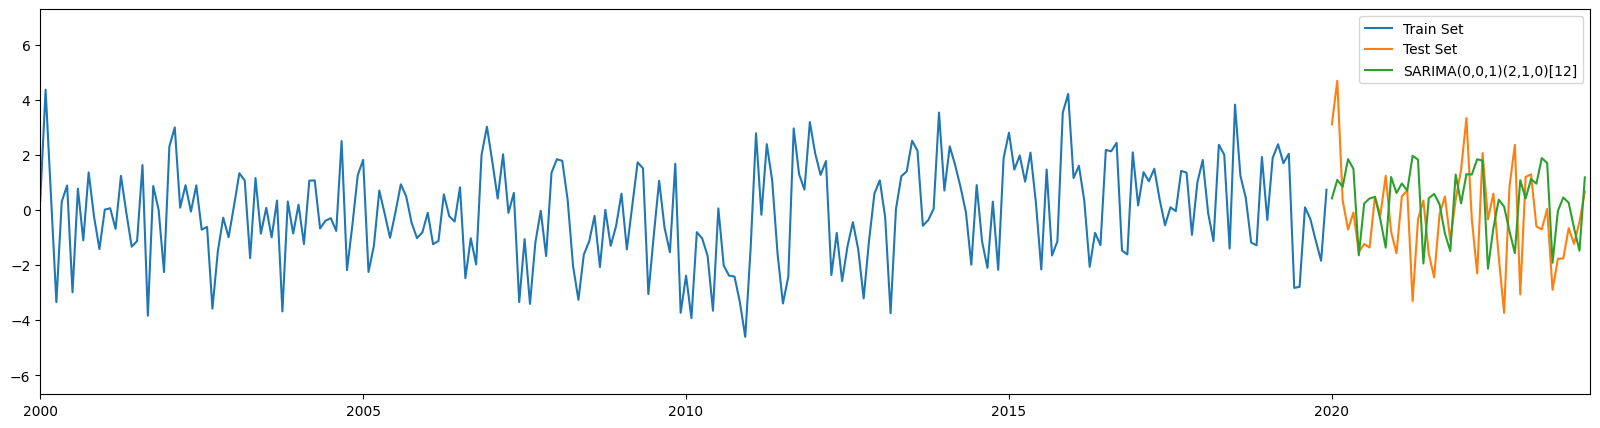

In [ ]:
plt.figure(figsize=[20,5])
plt.plot(np.arange(1825,2020,1/12),train.values,label="Train Set")
plt.plot(np.arange(2020,2024,1/12),test.values,label="Test Set")
plt.plot(np.arange(2020,2024,1/12),forecast_mean.values,label="SARIMA(0,0,1)(2,1,0)[12]")
plt.xlim(2000,2024)
plt.legend()

In [ ]:
#normalize before training SARIMA:
# normalize data to be between [0,1]:
max_value = NAO_monthly.NAO_index.max()
min_value = NAO_monthly.NAO_index.min()

norm_NAO = (NAO_monthly - min_value) / (max_value - min_value)

In [ ]:
norm_NAO

NAO_index
Date                 
1825-01-01   0.458386
1825-02-01   0.492763
1825-03-01   0.501888
1825-04-01   0.454452
1825-05-01   0.486469
...               ...
2023-08-01   0.338184
2023-09-01   0.424795
2023-10-01   0.379484
2023-11-01   0.442574
2023-12-01   0.528949

[2388 rows x 1 columns]

In [ ]:
# Split the data into train and test sets to evaluate the model
train_size = int(len(norm_NAO) * 0.8)
train, test = norm_NAO[:train_size], norm_NAO[train_size:]

In [ ]:
# Define the model
model = SARIMAX(train, order=(0,0,1), seasonal_order=(2,1,0,12))

# Fit the model
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

# Make predictions
forecast_periods = 478
forecast = model_fit.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                           NAO_index   No. Observations:                 1910
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                 827.564
Date:                             Wed, 10 Jul 2024   AIC                          -1647.128
Time:                                     08:43:27   BIC                          -1624.934
Sample:                                 01-01-1825   HQIC                         -1638.957
                                      - 02-01-1984                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0672      0.023      2.973      0.003       0.023       0.111
ar.S.L12      -0.6464      

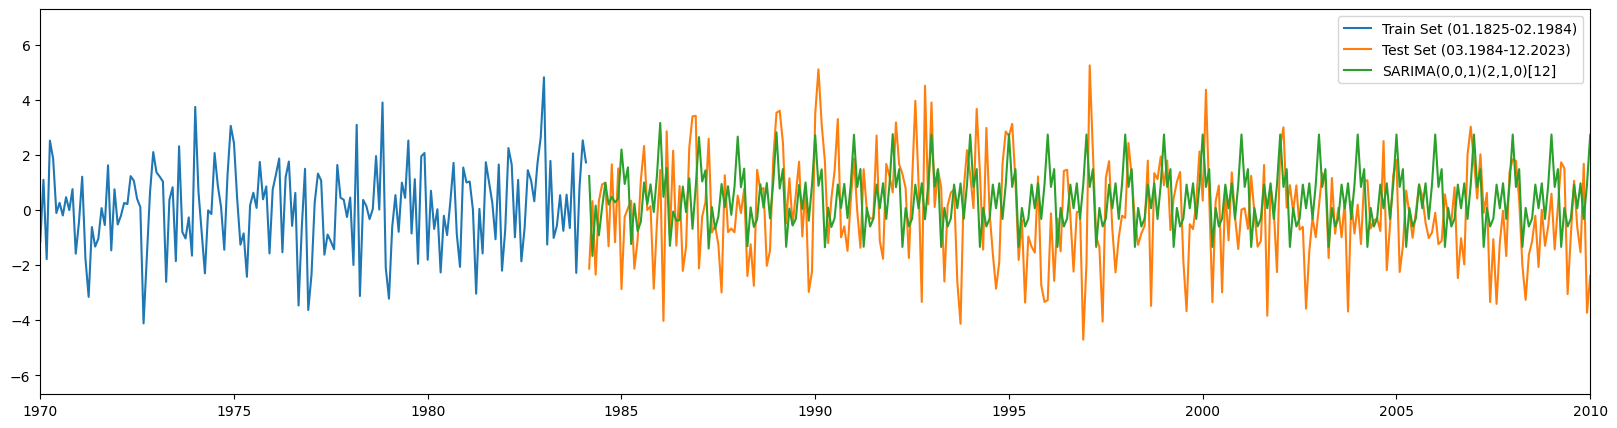

In [ ]:
plt.figure(figsize=[20,5])
plt.plot(np.arange(1825,1984.1,1/12),denorm(train.values),label="Train Set (01.1825-02.1984)")
plt.plot(np.arange(1984.16666667,2024,1/12),denorm(test.values),label="Test Set (03.1984-12.2023)")
plt.plot(np.arange(1984.16666667,2024,1/12),denorm(forecast_mean.values),label="SARIMA(0,0,1)(2,1,0)[12]")
plt.xlim(1970,2010)
plt.legend()
#plt.savefig("Baseline_NAO.png",dpi=200)

In [ ]:
mse = mean_squared_error(denorm(test),denorm(forecast_mean))
#smape = smape(test,forecast_mean)
print(f'Root Mean Squared Error: {(mse)}')
#print(f'Mean Absolute Percentage Error: {smape}')

Root Mean Squared Error: 4.011845087767766


In [ ]:
phase_check(denorm(test),denorm(forecast_mean))

38.07531380753138

(10.0, 34.0)

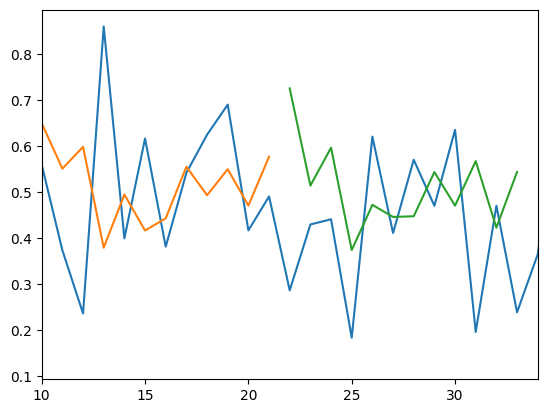

In [ ]:
plt.plot(train.values[:250])
plt.plot(np.arange(10,22,),forecast_mean.values[10:22])
plt.plot(np.arange(22,34),forecast_mean.values[22:34])
plt.xlim(10,34)

# Data Preprocessing: Normalize Data to [0,1]:



In [6]:
# normalize data to be between [0,1]:
norm_NAO_monthly,max_m,min_m = norm(NAO_monthly)
norm_NAO_daily,max_d,min_d = norm(NAO_daily)

# Data Preprocessing: Perform EEMD:
**Ensemble Empirical Mode Decomposition**

Ensemble empirical mode decomposition (EEMD) [Wu2009]_
is noise-assisted technique, which is meant to be more robust
than simple Empirical Mode Decomposition (EMD). The robustness is
checked by performing many decompositions on signals slightly
perturbed from their initial position. In the grand average over
all IMF results the noise will cancel each other out and the result
is pure decomposition.

Reference: https://iopscience.iop.org/article/10.1088/0964-1726/18/9/095004/pdf

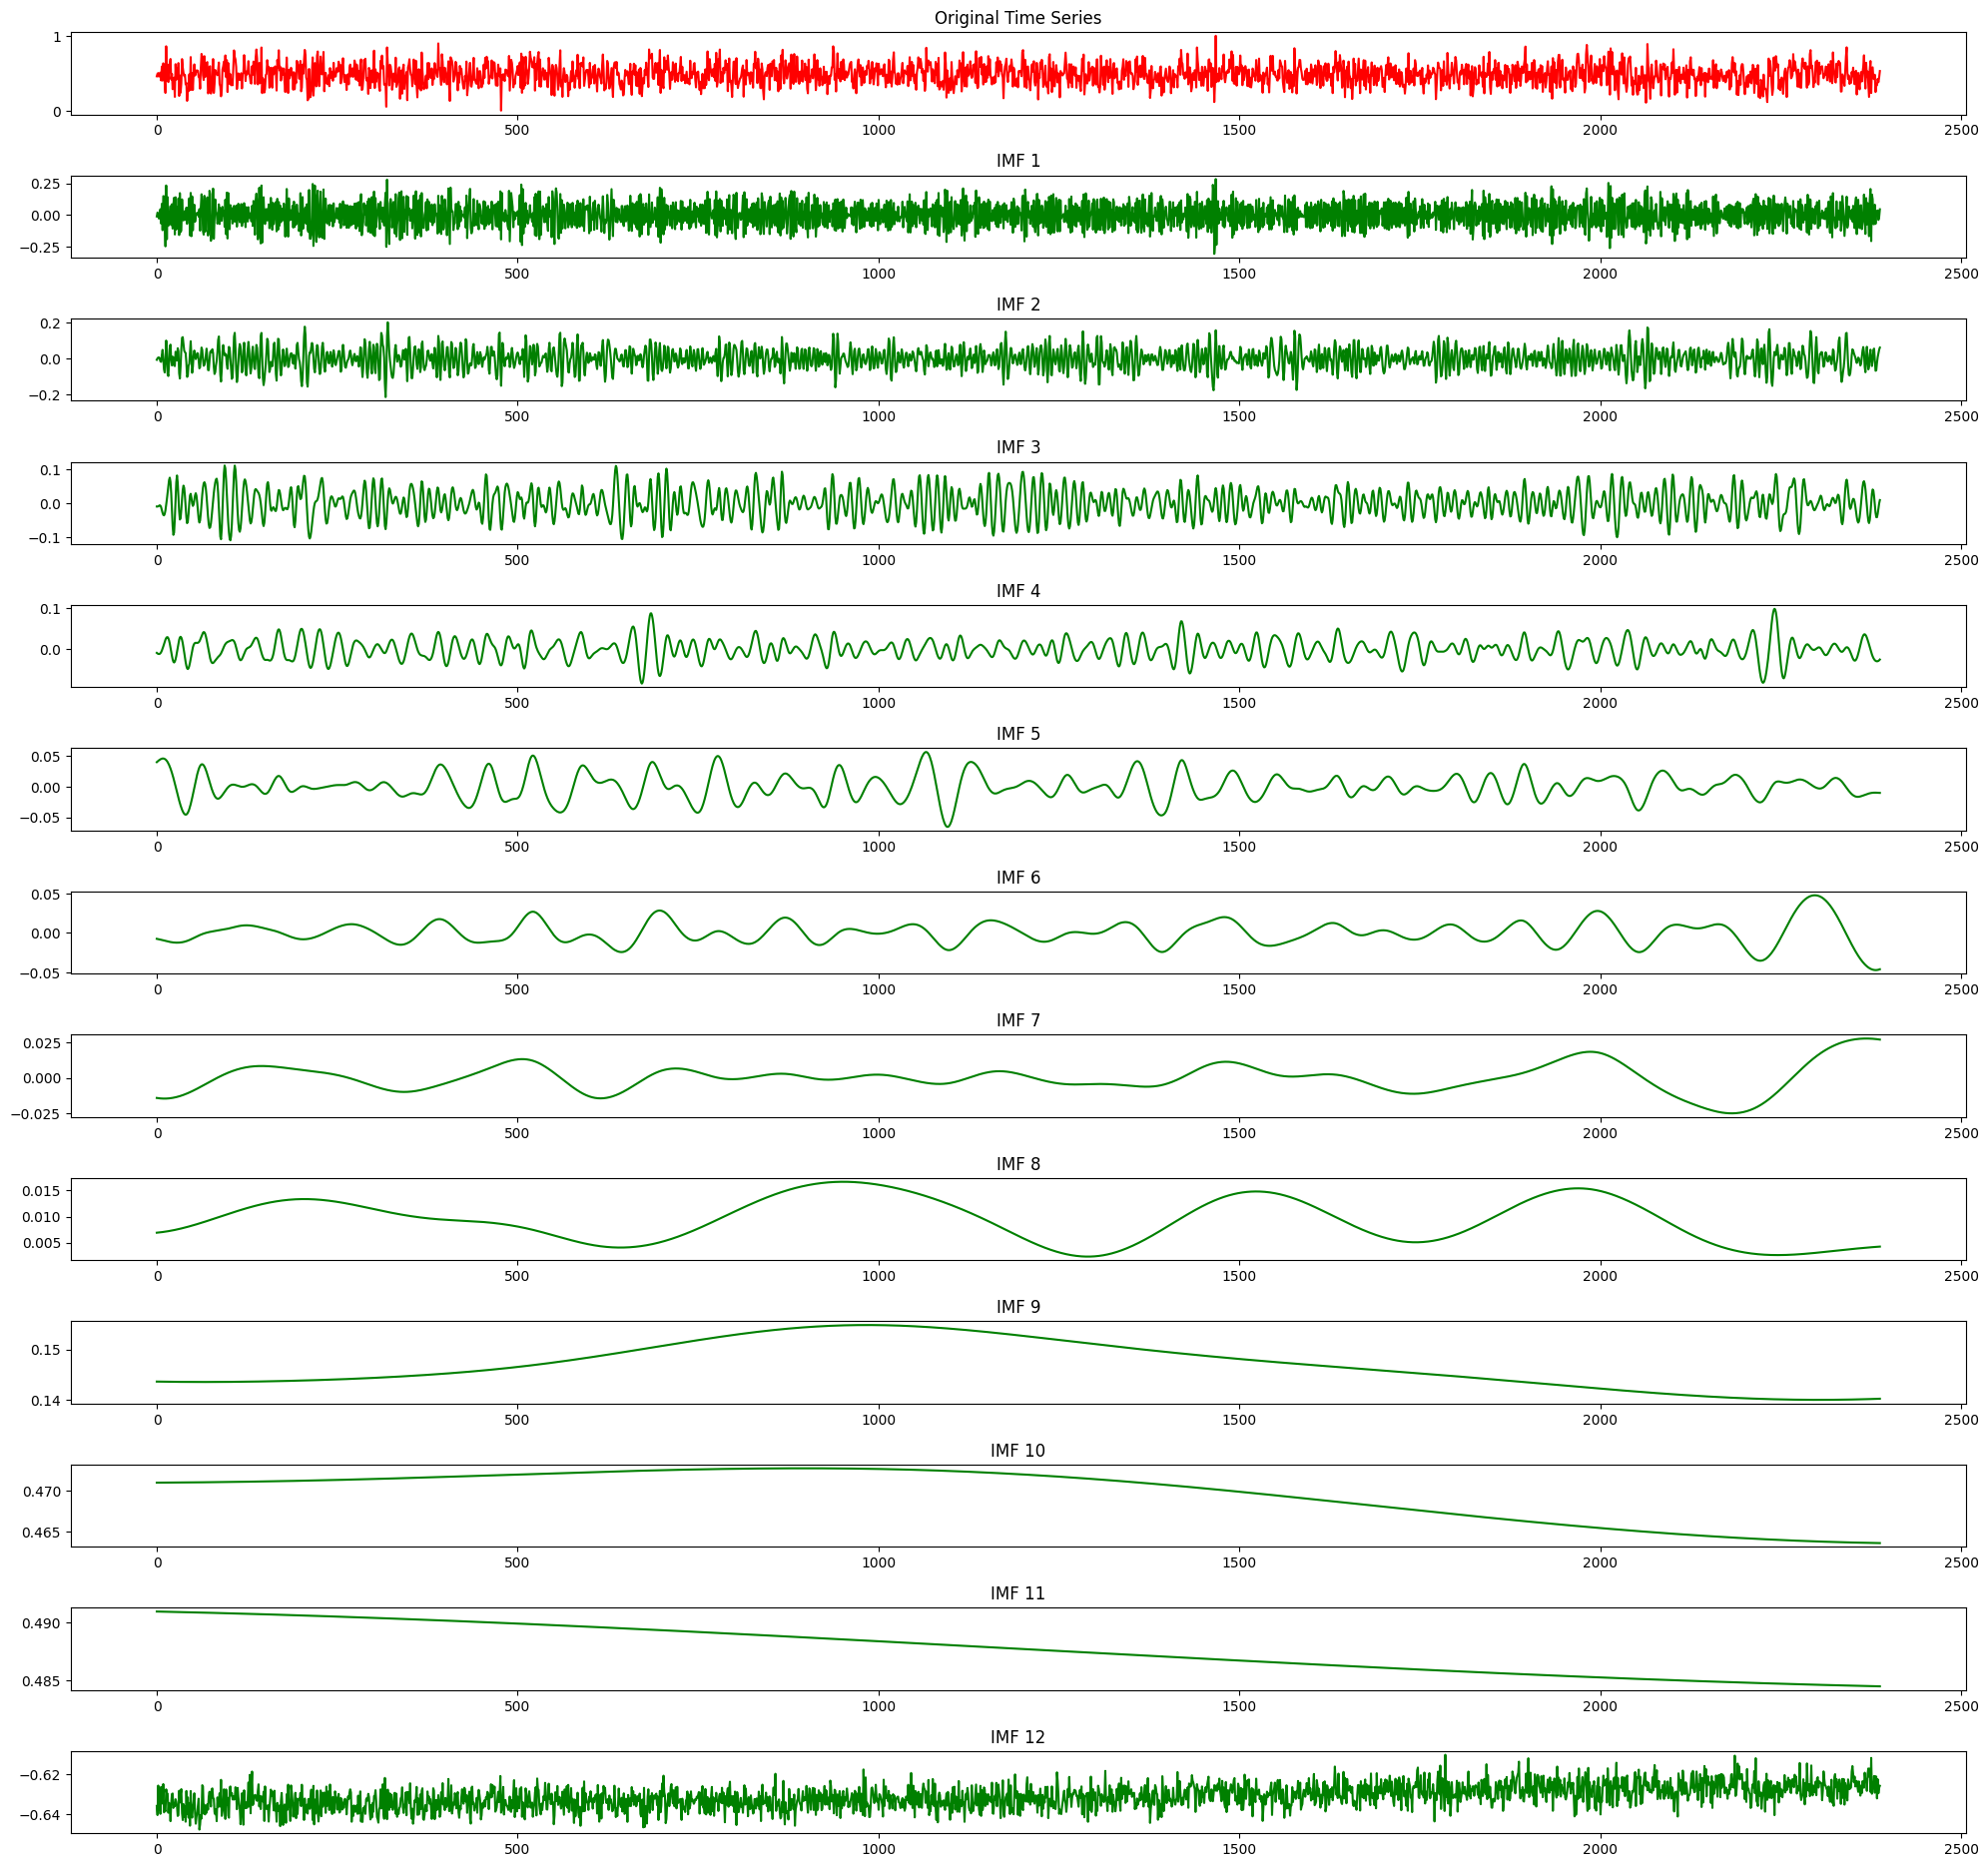

In [7]:
#EEMD of monthly data:
IMFs_monthly = perform_EEMD(norm_NAO_monthly.NAO_index)

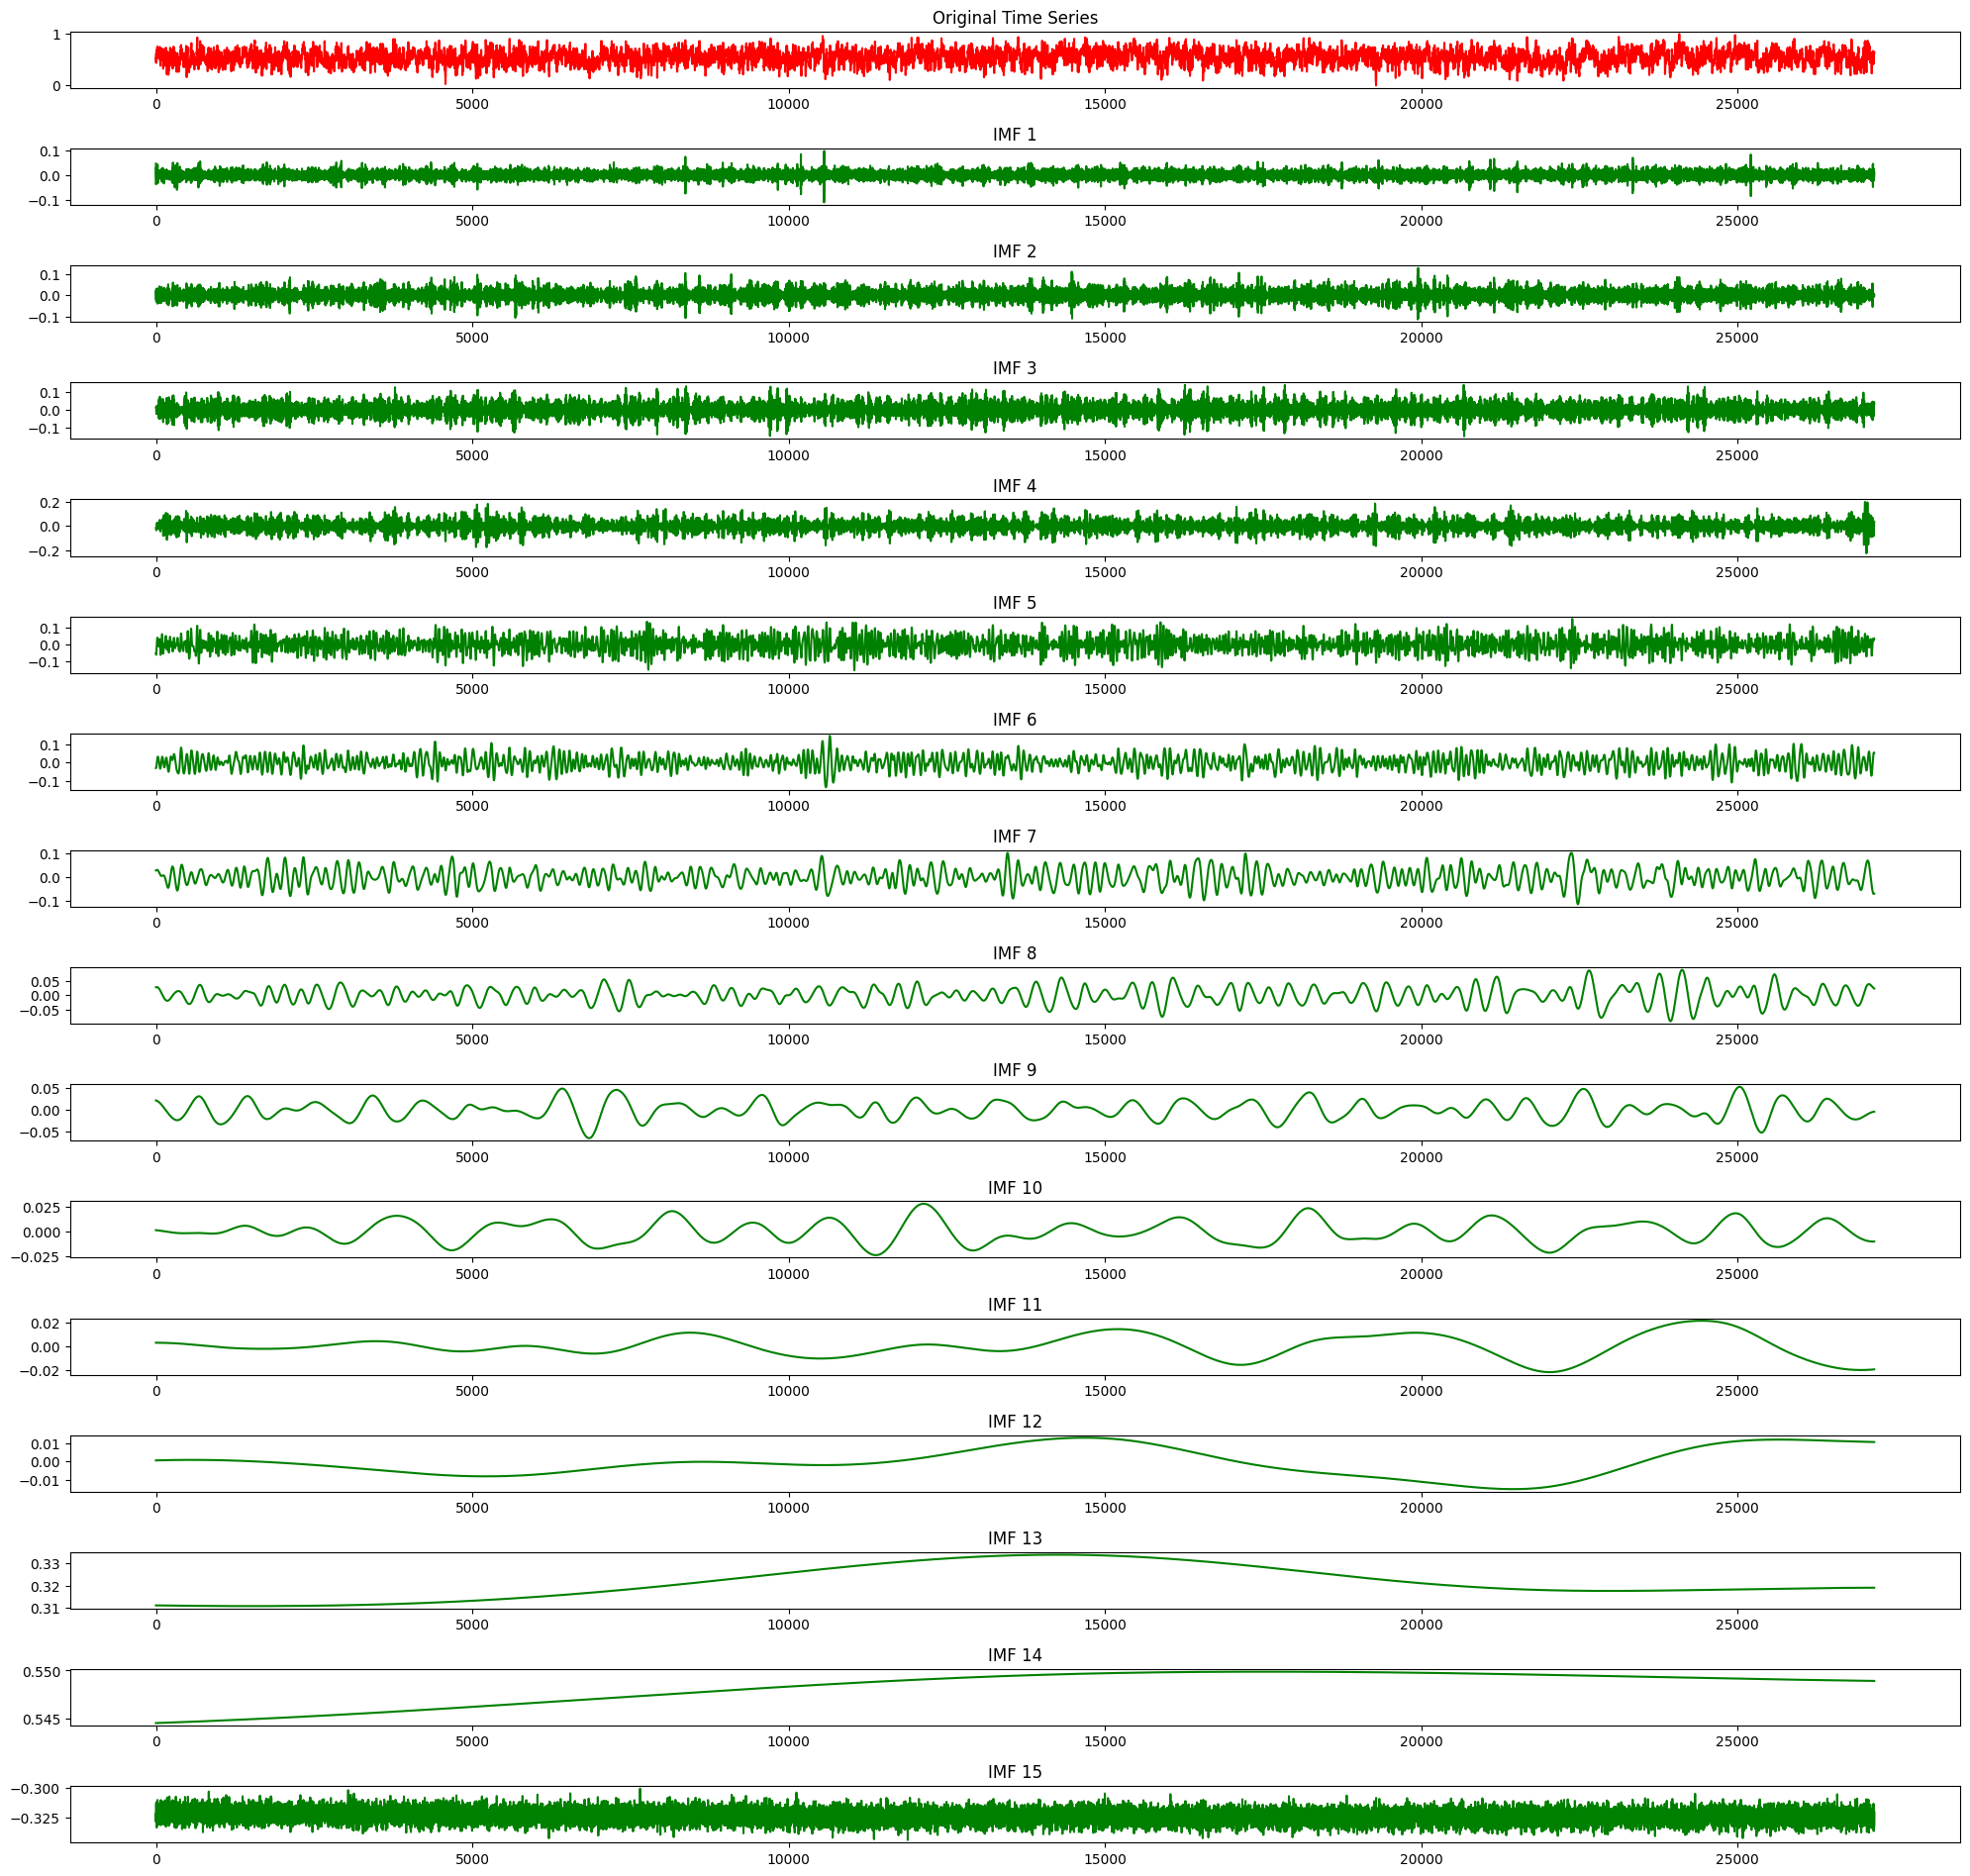

In [8]:
#EEMD of daily data:
IMFs_daily = perform_EEMD(norm_NAO_daily.nao_index_daily)

In [9]:
print(np.shape(IMFs_monthly))
print(np.shape(IMFs_daily))

(12, 2388)
(15, 27161)


<ipython-input-10-20f848a145a1>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap=cm.get_cmap('rainbow')


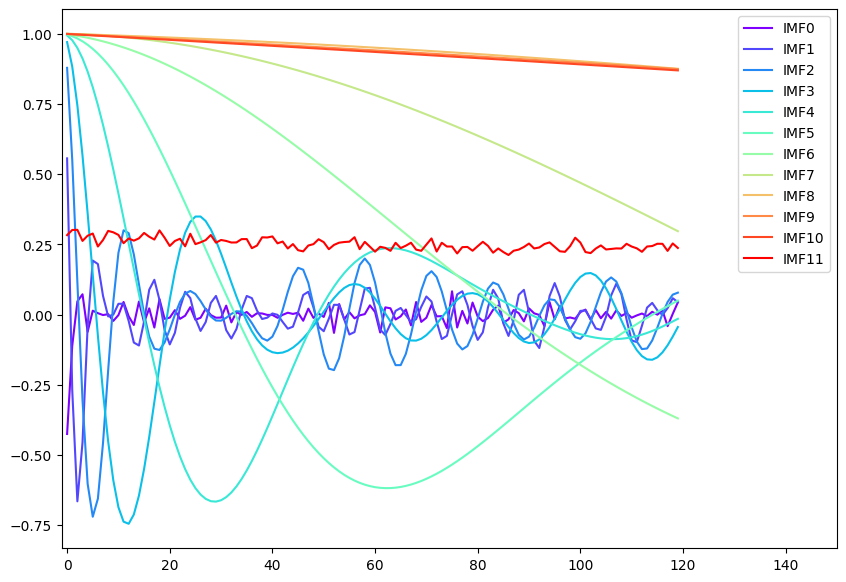

In [10]:
#Look at the autocorrelation functions for the IMFs of the monthly data:
import statsmodels.api as sm
import matplotlib.cm as cm
my_cmap=cm.get_cmap('rainbow')
colors=my_cmap(np.linspace(0,1,12))

autocorr_IMFs = [0]*np.shape(IMFs_monthly)[0]
plt.figure(figsize=[10,7])
for i in range(np.shape(IMFs_monthly)[0]):
 autocorr_IMFs[i] = sm.tsa.acf(IMFs_monthly[i],nlags=120)
 plt.plot(autocorr_IMFs[i][1:],label="IMF"+str(i),color=colors[i,:] )
plt.xlim(-1,150)
plt.legend()

<ipython-input-11-c276df07bb8f>:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  my_cmap=cm.get_cmap('rainbow')


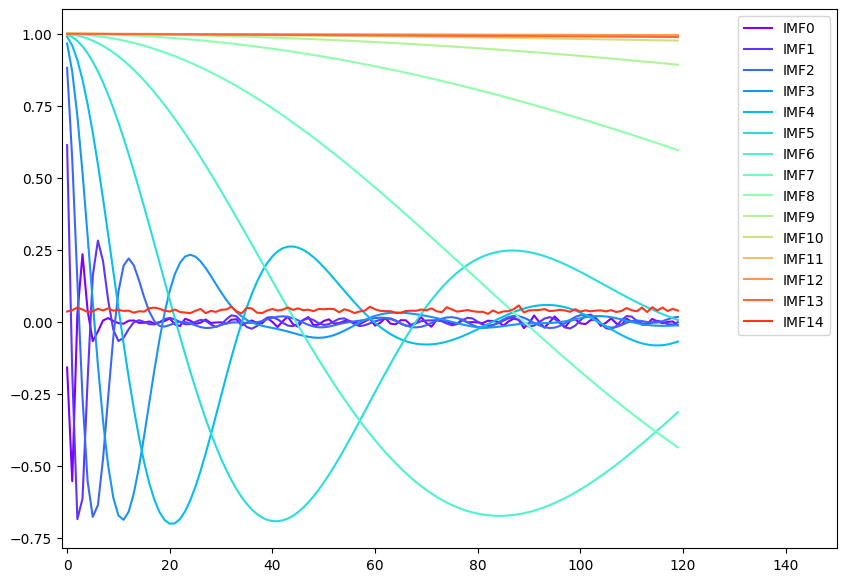

In [11]:
#Look at the autocorrelation functions for the IMFs of the daily data:
import statsmodels.api as sm
my_cmap=cm.get_cmap('rainbow')
colors=my_cmap(np.linspace(0,1,16))

autocorr_IMFs = [0]*np.shape(IMFs_daily)[0]
plt.figure(figsize=[10,7])
for i in range(np.shape(IMFs_daily)[0]):
 autocorr_IMFs[i] = sm.tsa.acf(IMFs_daily[i],nlags=120)
 plt.plot(autocorr_IMFs[i][1:],label="IMF"+str(i),color=colors[i,:] )
plt.xlim(-1,150)
plt.legend()

# Data Preprocessing: Prepare the Datasets:
here the train, (validation) and test datasets are created and the **input length** is chosen

In [38]:
#can be used for XGBoost, Randomn Forest and ConvLSTM (but LSTM needs further reshaping, see below)
#preparing data with EEMD
# preparing the data:
def create_dataset(IMFs, look_back=1):
    dataX, dataY = [], []
    for i in range(IMFs.shape[1] - look_back):
        a = IMFs[:, i:(i + look_back)]
        dataX.append(a)
        dataY.append(IMFs[:, i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 24  # Number of previous time steps to use as input features

X_IMF_monthly, y_IMF_monthly = create_dataset(IMFs_monthly, look_back)
X_IMF_daily, y_IMF_daily = create_dataset(IMFs_daily, look_back)

# Split data into train and test sets 80% for training, 20% for testing:
X_IMF_monthly_train,X_IMF_monthly_test = X_IMF_monthly.reshape(X_IMF_monthly.shape[0], -1)[:1892],X_IMF_monthly.reshape(X_IMF_monthly.shape[0], -1)[1892:]
y_IMF_monthly_train,y_IMF_monthly_test = y_IMF_monthly[:1892],y_IMF_monthly[1892:]

X_IMF_daily_train,X_IMF_daily_test = X_IMF_daily.reshape(X_IMF_daily.shape[0], -1)[:21910],X_IMF_daily.reshape(X_IMF_daily.shape[0], -1)[21910:]
y_IMF_daily_train,y_IMF_daily_test = y_IMF_daily[:21910],y_IMF_daily[21910:]

In [13]:
print(f' X_monthly_train: {np.shape(X_IMF_monthly_train)}, y_monthly_train: {np.shape(y_IMF_monthly_train)}, X_monthly_test: {np.shape(X_IMF_monthly_test)}, y_monthly_test: {np.shape(y_IMF_monthly_test)}')
print(f' X_daily_train: {np.shape(X_IMF_daily_train)}, y_daily_train: {np.shape(y_IMF_daily_train)}, X_daily_test: {np.shape(X_IMF_daily_test)}, y_daily_test: {np.shape(y_IMF_daily_test)}')


 X_monthly_train: (1892, 288), y_monthly_train: (1892, 12), X_monthly_test: (472, 288), y_monthly_test: (472, 12)
 X_daily_train: (21910, 360), y_daily_train: (21910, 15), X_daily_test: (5227, 360), y_daily_test: (5227, 15)


In [14]:
#can be used for XGBoost, Randomn Forest and ConvLSTM (but LSTM needs further reshaping, see below)
#preparing data without EEMD (just the original time series but normalized)
# Function to create dataset from a single time series
def create_dataset(original_time_series, look_back=1):
    dataX, dataY = [], []
    for i in range(len(original_time_series) - look_back):
        a = original_time_series[i:(i + look_back)]
        dataX.append(a)
        dataY.append(original_time_series[i + look_back])
    return np.array(dataX), np.array(dataY)

look_back = 24  # Number of previous time steps to use as input features
X_monthly, y_monthly = create_dataset(norm_NAO_monthly.NAO_index.values, look_back)
X_daily, y_daily = create_dataset(norm_NAO_daily.nao_index_daily.values, look_back)

# Split data into train and test sets 80% for training, 20% for testing:
X_monthly_train,X_monthly_test = X_monthly.reshape(X_monthly.shape[0], -1)[:1892],X_monthly.reshape(X_monthly.shape[0], -1)[1892:]
y_monthly_train,y_monthly_test = y_monthly[:1892],y_monthly[1892:]

X_daily_train,X_daily_test = X_daily.reshape(X_daily.shape[0], -1)[:21910],X_daily.reshape(X_daily.shape[0], -1)[21910:]
y_daily_train,y_daily_test = y_daily[:21910],y_daily[21910:]

In [15]:
print(f' X_monthly_train: {np.shape(X_monthly_train)}, y_monthly_train: {np.shape(y_monthly_train)}, X_monthly_test: {np.shape(X_monthly_test)}, y_monthly_test: {np.shape(y_monthly_test)}')
print(f' X_daily_train: {np.shape(X_daily_train)}, y_daily_train: {np.shape(y_daily_train)}, X_daily_test: {np.shape(X_daily_test)}, y_daily_test: {np.shape(y_daily_test)}')


 X_monthly_train: (1892, 24), y_monthly_train: (1892,), X_monthly_test: (472, 24), y_monthly_test: (472,)
 X_daily_train: (21910, 24), y_daily_train: (21910,), X_daily_test: (5227, 24), y_daily_test: (5227,)


In [119]:
# Further reshaping for ConvLSTM, based on the previously computed datasets:
# Reshape input data to be 5-dimensional (samples, time_steps, rows, cols, channels)
# Here, rows = number of IMFs, cols = 1 (since it's 1D time series for each IMF), channels = 1 (single feature per time step)
def reshape_X(X):
  X_reshaped = X.reshape((X.shape[0], look_back, X.shape[1], 1, 1))
  return X_reshaped
#reshaped with EEMD:
#X_IMF_monthly_rs = reshape_X(X_EEMD_monthly)
#X_IMF_daily_rs = reshape_X(X_IMF_daily)
#reshaped without EEMD:
#X_monthly_rs = reshape_X(X_monthly)
#X_daily_rs = reshape_X(X_daily)

# Split data into train, validation, and test sets
#X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=0)
#X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

# XGBoost

## XGBoost, monthly, without EEMD:

In [23]:
#fit an XGBoost Model, here without EEMD, just the normalized time series:

# Initial model setup:
model_XGB_monthly = xgb.XGBRegressor(n_estimators=500,learning_rate=0.2)
#train with traning data:
model_XGB_monthly.fit(X_monthly_train, y_monthly_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
#make prediction with test set:
y_monthly_pred = model_XGB_monthly.predict(X_monthly_test)

In [25]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(y_monthly_test,max_m,min_m), denorm(y_monthly_pred,max_m,min_m)),2)
phase_agreement = np.round(phase_check(denorm(y_monthly_test,max_m,min_m), denorm(y_monthly_pred,max_m,min_m)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 3.72
Phase Agreement: 39.19%


## XGBoost, monthly, with EEMD

In [17]:
#fit an XGBoost Model, here with EEMD:

# Initial model setup:
model_XGB_IMF_monthly = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
#train with traning data:
model_XGB_IMF_monthly.fit(X_IMF_monthly_train, y_IMF_monthly_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
#make prediction with test set:
y_IMF_monthly_pred = model_XGB_IMF_monthly.predict(X_IMF_monthly_test)

In [19]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(np.sum(y_IMF_monthly_test,axis=1),max_m,min_m), denorm(np.sum(y_IMF_monthly_pred,axis=1),max_m,min_m)),2)
phase_agreement = np.round(phase_check(denorm(np.sum(y_IMF_monthly_test,axis=1),max_m,min_m), denorm(np.sum(y_IMF_monthly_pred,axis=1),max_m,min_m)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 1.09
Phase Agreement: 69.28%


(1984.0, 2024.0)

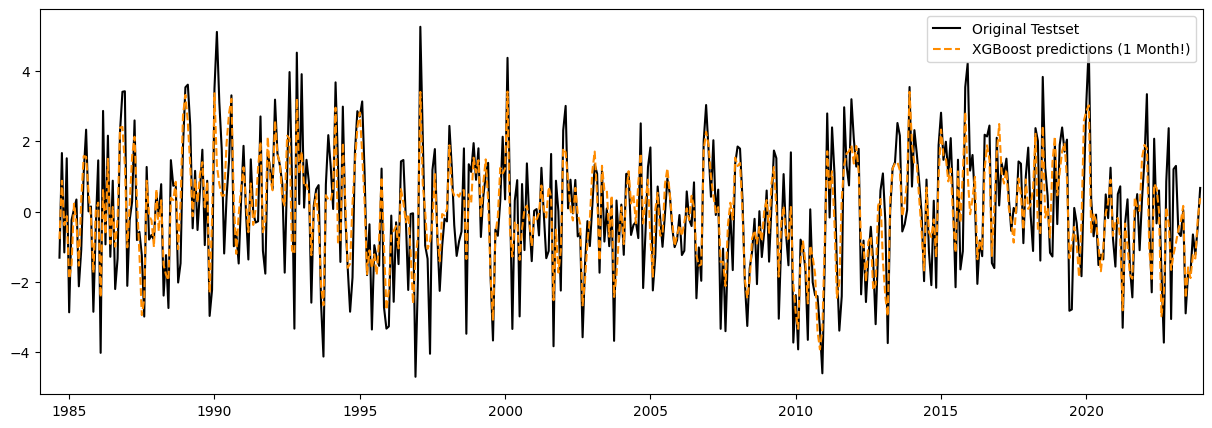

In [20]:
#visualisation:
plt.figure(figsize=[15,5])
plt.plot(np.arange(1982.66666667,2024,1/12)[24:],denorm(np.sum(y_IMF_monthly_test, axis=1),max_m,min_m),color="k",label="Original Testset")
plt.plot(np.arange(1982.66666667,2024,1/12)[24:],denorm(np.sum(y_IMF_monthly_pred, axis=1),max_m,min_m),linestyle="--",color="darkorange",label="XGBoost predictions (1 Month!)")
plt.legend()
plt.xlim(1984,2024)
#plt.savefig("XGBoost_EEMD.png",dpi=200)

## XGBoost, daily, without EEMD

In [30]:
#fit an XGBoost Model for the daily data, here without EEMD:

# Initial model setup:
model_XGB_daily = xgb.XGBRegressor(n_estimators=500,learning_rate=0.2)
#train with traning data:
model_XGB_daily.fit(X_daily_train, y_daily_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
#make prediction with test set:
y_daily_pred = model_XGB_daily.predict(X_daily_test)

In [32]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(y_daily_test,max_d,min_d), denorm(y_daily_pred,max_d,min_d)),3)
phase_agreement = np.round(phase_check(denorm(y_daily_test,max_d,min_d), denorm(y_daily_pred,max_d,min_d)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 0.053
Phase Agreement: 91.41%


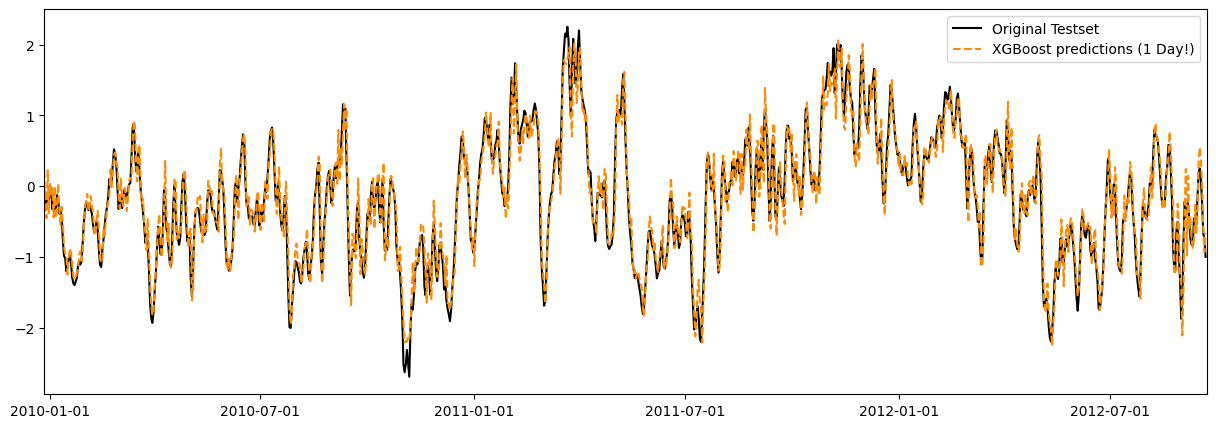

In [33]:
#visualisation:
plt.figure(figsize=[15,5])
plt.plot(norm_NAO_daily[21910:22910].index,denorm(y_daily_test,max_d,min_d)[:1000],color="k",label="Original Testset")
plt.plot(norm_NAO_daily[21910:22910].index,denorm(y_daily_pred,max_d,min_d)[:1000],linestyle="--",color="darkorange",label="XGBoost predictions (1 Day!)")
plt.legend()
plt.xticks(ticks=[5,186,370,551,735,917]);
plt.xlim(0,1000);

## XGBoost, daily, with EEMD

In [21]:
#fit an XGBoost Model for the daily data, here with EEMD:

# Initial model setup:
model_XGB_IMF_daily = xgb.XGBRegressor(n_estimators=500,learning_rate=0.2)
#train with traning data:
model_XGB_IMF_daily.fit(X_IMF_daily_train, y_IMF_daily_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
#make prediction with test set:
y_IMF_daily_pred = model_XGB_IMF_daily.predict(X_IMF_daily_test)

In [23]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(np.sum(y_IMF_daily_test,axis=1),max_d,min_d), denorm(np.sum(y_IMF_daily_pred,axis=1),max_d,min_d)),3)
phase_agreement = np.round(phase_check(denorm(np.sum(y_IMF_daily_test,axis=1),max_d,min_d), denorm(np.sum(y_IMF_daily_pred,axis=1),max_d,min_d)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 0.006
Phase Agreement: 96.98%


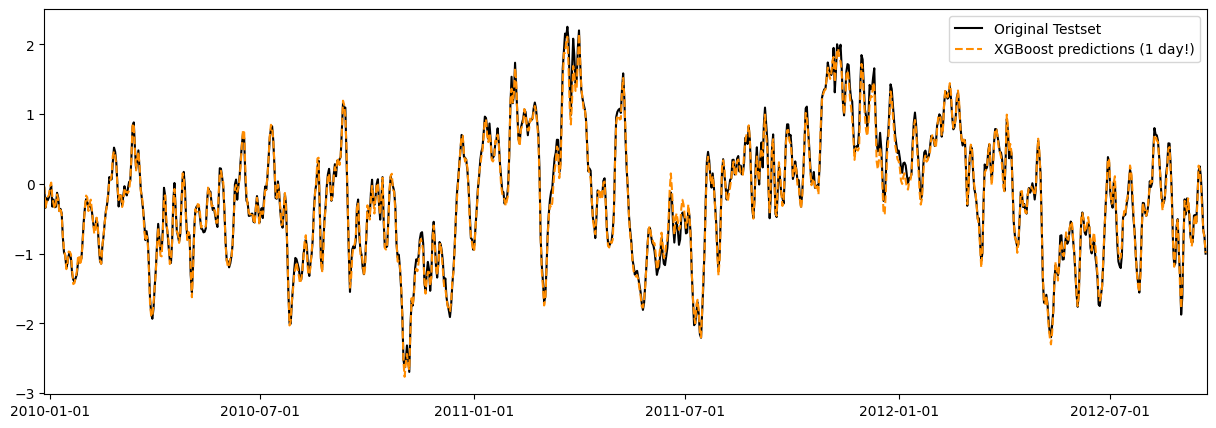

In [24]:
#visualisation:
plt.figure(figsize=[15,5])
plt.plot(norm_NAO_daily[21910:22910].index,denorm(np.sum(y_IMF_daily_test, axis=1),max_d,min_d)[:1000],color="k",label="Original Testset")
plt.plot(norm_NAO_daily[21910:22910].index,denorm(np.sum(y_IMF_daily_pred, axis=1),max_d,min_d)[:1000],linestyle="--",color="darkorange",label="XGBoost predictions (1 day!)")
plt.legend()
plt.xticks(ticks=[5,186,370,551,735,917]);
plt.xlim(0,1000);

## perform Rolling Forecast with the two EEMD models:

(-0.25, 0.25)

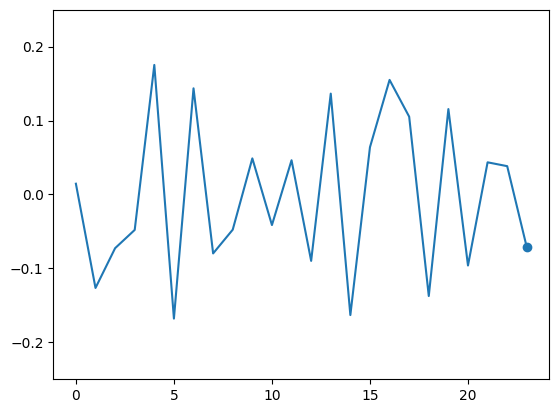

In [93]:
plt.plot(X_IMF_monthly_test[0,:24])
plt.scatter(23,X_IMF_monthly_test[:1,:][:,23])
plt.ylim(-0.25,0.25)

In [36]:
#rolling forecast to perform more months of NAO Prediction:
y_zero = model_XGB_IMF_monthly.predict(X_IMF_monthly_test[:1,:])

In [118]:
forecast_window = 10
X_IMF_monthly_test_reshaped = X_IMF_monthly_test.reshape(472,12,24)
predictions= []
for i in range(np.shape(X_IMF_monthly_test)[0]):
  X_forecast = X_IMF_monthly_test[i:i+1,:]

  for j in range(forecast_window):

    #make prediction with the set of 24 months:
    y_zero = model_XGB_IMF_monthly.predict(X_forecast)
    #save prediction in prediction list:
    predictions.append(np.sum(y_zero))
    #remove first month and add prediction to the end to get new X:
    new_X = X_IMF_monthly_test_reshaped[i,:,1:]
    X_forecast = np.concatenate((new_X, y_zero.T), axis=1).reshape(1,288)

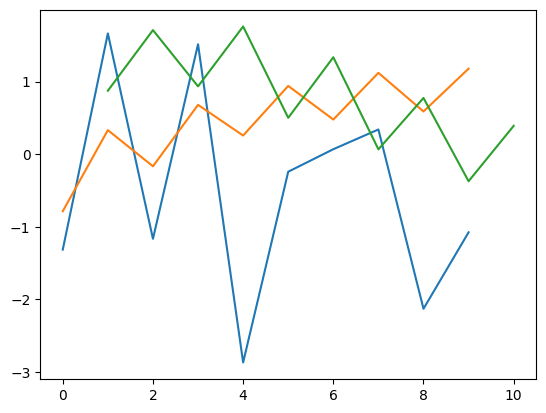

In [117]:
plt.plot(denorm(np.sum(y_IMF_monthly_test,axis=1)[:10],max_m,min_m))
plt.plot(np.arange(0,10),denorm(predictions[:10],max_m,min_m))
plt.plot(np.arange(1,11),denorm(predictions[10:],max_m,min_m))

# Random Forest

## Random Forest, monthly, without EEMD:

In [38]:
#fit random forest model for monthly data, without EEMD:

# Initialize Random Forest model
model_RF_monthly = RandomForestRegressor()

# Fit the model
model_RF_monthly.fit(X_monthly_train, y_monthly_train)

RandomForestRegressor()

In [39]:
#make prediction and evaluate:
y_RF_monthly_pred = model_RF_monthly.predict(X_monthly_test)

In [40]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(y_monthly_test,max_m,min_m), denorm(y_RF_monthly_pred,max_m,min_m)),2)
phase_agreement = np.round(phase_check(denorm(y_monthly_test,max_m,min_m), denorm(y_RF_monthly_pred,max_m,min_m)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 3.22
Phase Agreement: 38.77%


## Random Forest, monthly, with EEMD

In [41]:
#fit random forest model for monthly data, with EEMD:

# Initialize Random Forest model
model_RF_IMF_monthly = RandomForestRegressor()

# Fit the model
model_RF_IMF_monthly.fit(X_IMF_monthly_train, y_IMF_monthly_train)


RandomForestRegressor()

In [42]:
#make prediction and evaluate:
y_RF_IMF_monthly_pred = model_RF_IMF_monthly.predict(X_IMF_monthly_test)

In [43]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(np.sum(y_IMF_monthly_test,axis=1),max_m,min_m), denorm(np.sum(y_RF_IMF_monthly_pred,axis=1),max_m,min_m)),2)
phase_agreement = np.round(phase_check(denorm(np.sum(y_IMF_monthly_test,axis=1),max_m,min_m), denorm(np.sum(y_RF_IMF_monthly_pred,axis=1),max_m,min_m)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 1.99
Phase Agreement: 54.66%


## Random Forest, daily, without EEMD

In [44]:
#fit random forest model for daily data, without EEMD:

# Initialize Random Forest model
model_RF_daily = RandomForestRegressor()

# Fit the model
model_RF_daily.fit(X_daily_train, y_daily_train)

RandomForestRegressor()

In [45]:
#make prediction and evaluate:
y_RF_daily_pred = model_RF_daily.predict(X_daily_test)

In [46]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(y_daily_test,max_d,min_d), denorm(y_RF_daily_pred,max_d,min_d)),4)
phase_agreement = np.round(phase_check(denorm(y_daily_test,max_d,min_d), denorm(y_RF_daily_pred,max_d,min_d)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 0.0507
Phase Agreement: 90.97%


## Random Forest, daily, with EEMD

In [47]:
#fit random forest model for daily data, with EEMD:

# Initialize Random Forest model
model_RF_IMF_daily = RandomForestRegressor()

# Fit the model
model_RF_IMF_daily.fit(X_IMF_daily_train, y_IMF_daily_train)

RandomForestRegressor()

In [48]:
#make prediction and evaluate:
y_RF_IMF_daily_pred = model_RF_IMF_daily.predict(X_IMF_daily_test)

In [49]:
#evaluate using mean squared error and phase agreement:
mse = np.round(mean_squared_error(denorm(np.sum(y_IMF_daily_test,axis=1),max_d,min_d), denorm(np.sum(y_RF_IMF_daily_pred,axis=1),max_d,min_d)),4)
phase_agreement = np.round(phase_check(denorm(np.sum(y_IMF_daily_test,axis=1),max_d,min_d), denorm(np.sum(y_RF_IMF_daily_pred,axis=1),max_d,min_d)),2)
print(f'Mean Squared Error: {mse}')
print(f'Phase Agreement: {phase_agreement}%')

Mean Squared Error: 0.1255
Phase Agreement: 84.35%


# ConvLSTM
This part is not functional in the current notebook, but previous results were not very promising, so it was only kept for the sake of completeness, but not further edited.

In [ ]:
X_train,X_val,X_test = X[:1513,:,:].reshape((1513, 24,12, 1, 1)),X[1513:1892,:].reshape((379, 24,12, 1, 1)),X[1892:,:,:].reshape((472, 24,12, 1, 1))
y_train,y_val,y_test = np.sum(y[:1513,:],axis=1),np.sum(y[1513:1892,:],axis=1),np.sum(y[1892:,:],axis=1)

## Initialize and fit the model: ConvLSTM

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
# Build ConvLSTM model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

model = Sequential()
model.add(ConvLSTM2D(filters=128, kernel_size=(3, 1), activation='relu', input_shape=(look_back, 12, 1, 1), return_sequences=True))
model.add(Dropout(0.3))
model.add(ConvLSTM2D(filters=64, kernel_size=(3, 1), activation='relu', return_sequences=True))  # Add return_sequences=True
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(1))  # Output layer should match the number of IMFs

model.compile(optimizer='adam', loss='mse')

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
lr_scheduler = LearningRateScheduler(scheduler)

# Train the model with validation data and callbacks
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=2, validation_data=(X_val, y_val), callbacks=[reduce_lr, early_stopping,lr_scheduler])

Epoch 1/20
95/95 - 64s - loss: 0.0321 - val_loss: 0.0162 - lr: 0.0010 - 64s/epoch - 672ms/step
Epoch 2/20
95/95 - 44s - loss: 0.0209 - val_loss: 0.0162 - lr: 0.0010 - 44s/epoch - 459ms/step
Epoch 3/20
95/95 - 32s - loss: 0.0209 - val_loss: 0.0162 - lr: 0.0010 - 32s/epoch - 342ms/step
Epoch 4/20
95/95 - 34s - loss: 0.0213 - val_loss: 0.0196 - lr: 0.0010 - 34s/epoch - 361ms/step
Epoch 5/20
95/95 - 35s - loss: 0.0199 - val_loss: 0.0155 - lr: 0.0010 - 35s/epoch - 371ms/step
Epoch 6/20
95/95 - 34s - loss: 0.0185 - val_loss: 0.0152 - lr: 0.0010 - 34s/epoch - 363ms/step
Epoch 7/20
95/95 - 34s - loss: 0.0181 - val_loss: 0.0199 - lr: 0.0010 - 34s/epoch - 362ms/step
Epoch 8/20
95/95 - 33s - loss: 0.0169 - val_loss: 0.0141 - lr: 0.0010 - 33s/epoch - 349ms/step
Epoch 9/20
95/95 - 36s - loss: 0.0154 - val_loss: 0.0171 - lr: 0.0010 - 36s/epoch - 374ms/step
Epoch 10/20
95/95 - 33s - loss: 0.0151 - val_loss: 0.0127 - lr: 0.0010 - 33s/epoch - 353ms/step
Epoch 11/20
95/95 - 34s - loss: 0.0146 - val_loss

## Make predictions and evaluate the Model: ConvLSTM

In [ ]:
last_2y = IMFs[:,2364:].reshape(1,24,12,1,1)

In [ ]:
np.shape(X_test)

(472, 24, 12, 1, 1)

In [ ]:
new_NAO  = model.predict(last_2y)

1/1 [==============================] - 0s 118ms/step


In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
mse = mean_squared_error(denorm(y_test),denorm(y_pred))
print(f"Mean Squared Error on Test Set: {mse}")

15/15 [==============================] - 3s 142ms/step
Mean Squared Error on Test Set: 1.7553353528178495


In [ ]:
denorm(new_NAO)

array([[-0.652647]], dtype=float32)

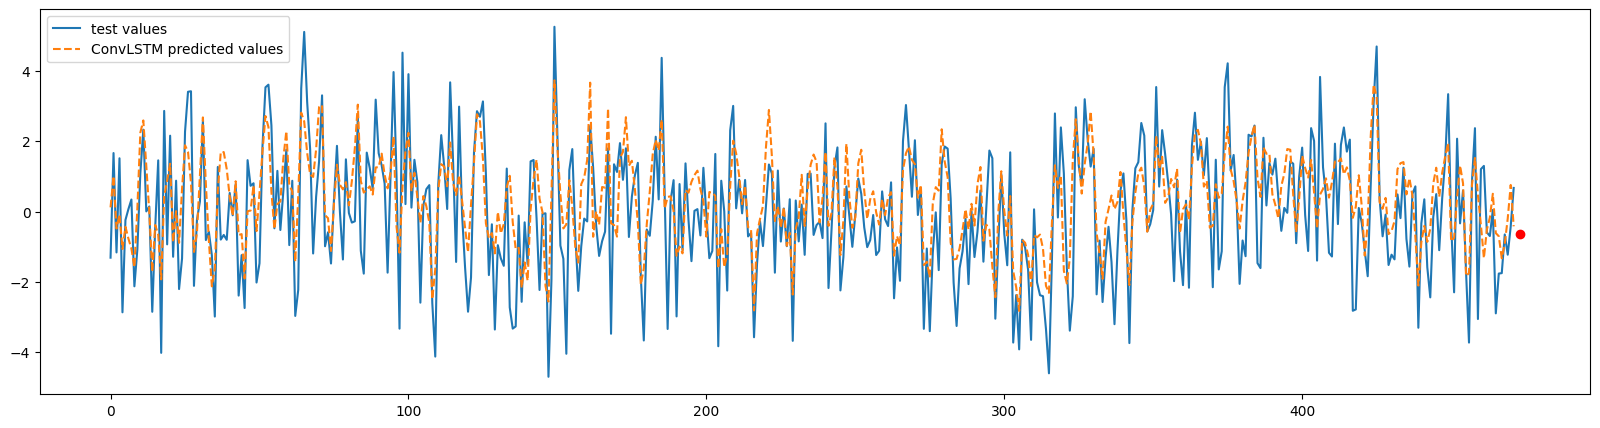

In [ ]:
plt.figure(figsize=[20,5])
plt.plot(denorm(y_test),label="test values")
plt.plot(denorm(y_pred),linestyle="--",label="ConvLSTM predicted values")
plt.scatter(473,denorm(new_NAO),c="r")
#NAO_monthly.NAO_index[1916:].plot()
plt.legend()

In [ ]:
phase_check(denorm(y_test), denorm(y_pred))

57.62711864406779

<Axes: xlabel='Date'>

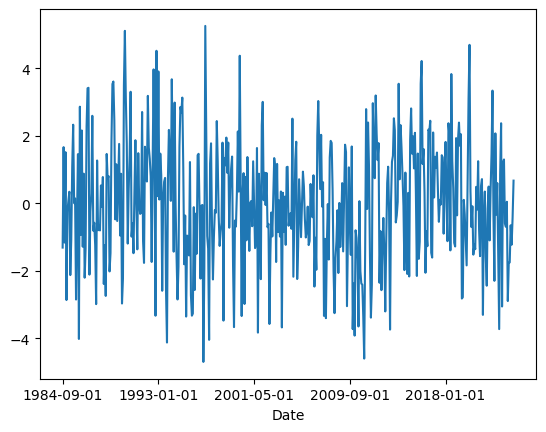

In [ ]:
NAO_monthly.NAO_index[1916:].plot()

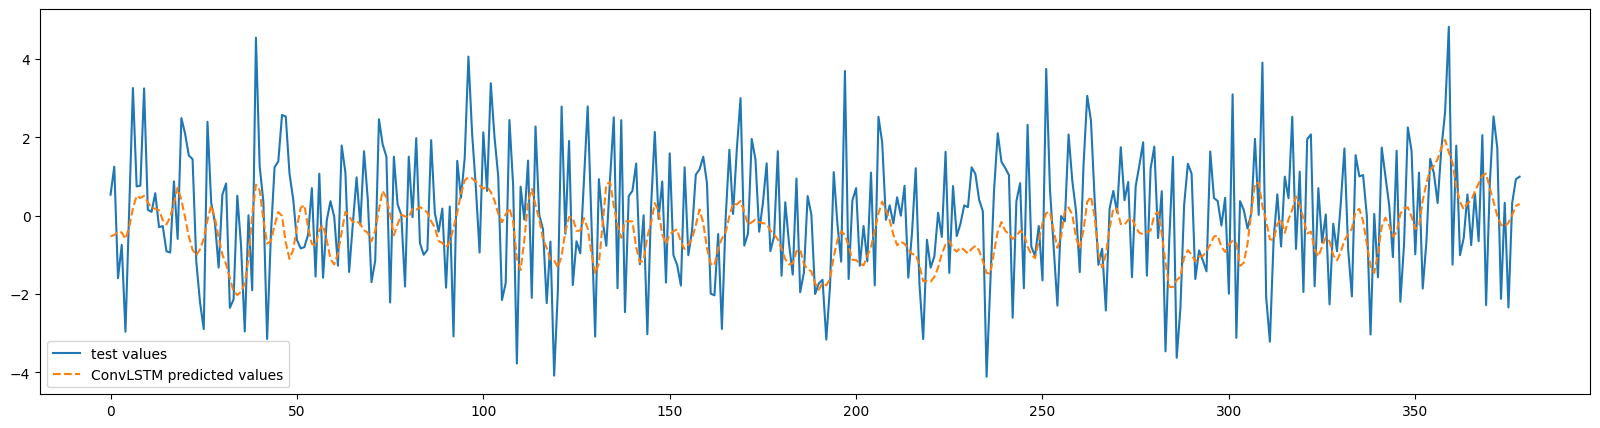

In [ ]:
plt.figure(figsize=[20,5])
plt.plot(np.sum(denorm_IMFs(y_val), axis=1),label="test values")
plt.plot(np.sum(denorm_IMFs(y_pred_val), axis=1),linestyle="--",label="ConvLSTM predicted values")
#NAO_monthly.NAO_index[1916:].plot()
plt.legend()

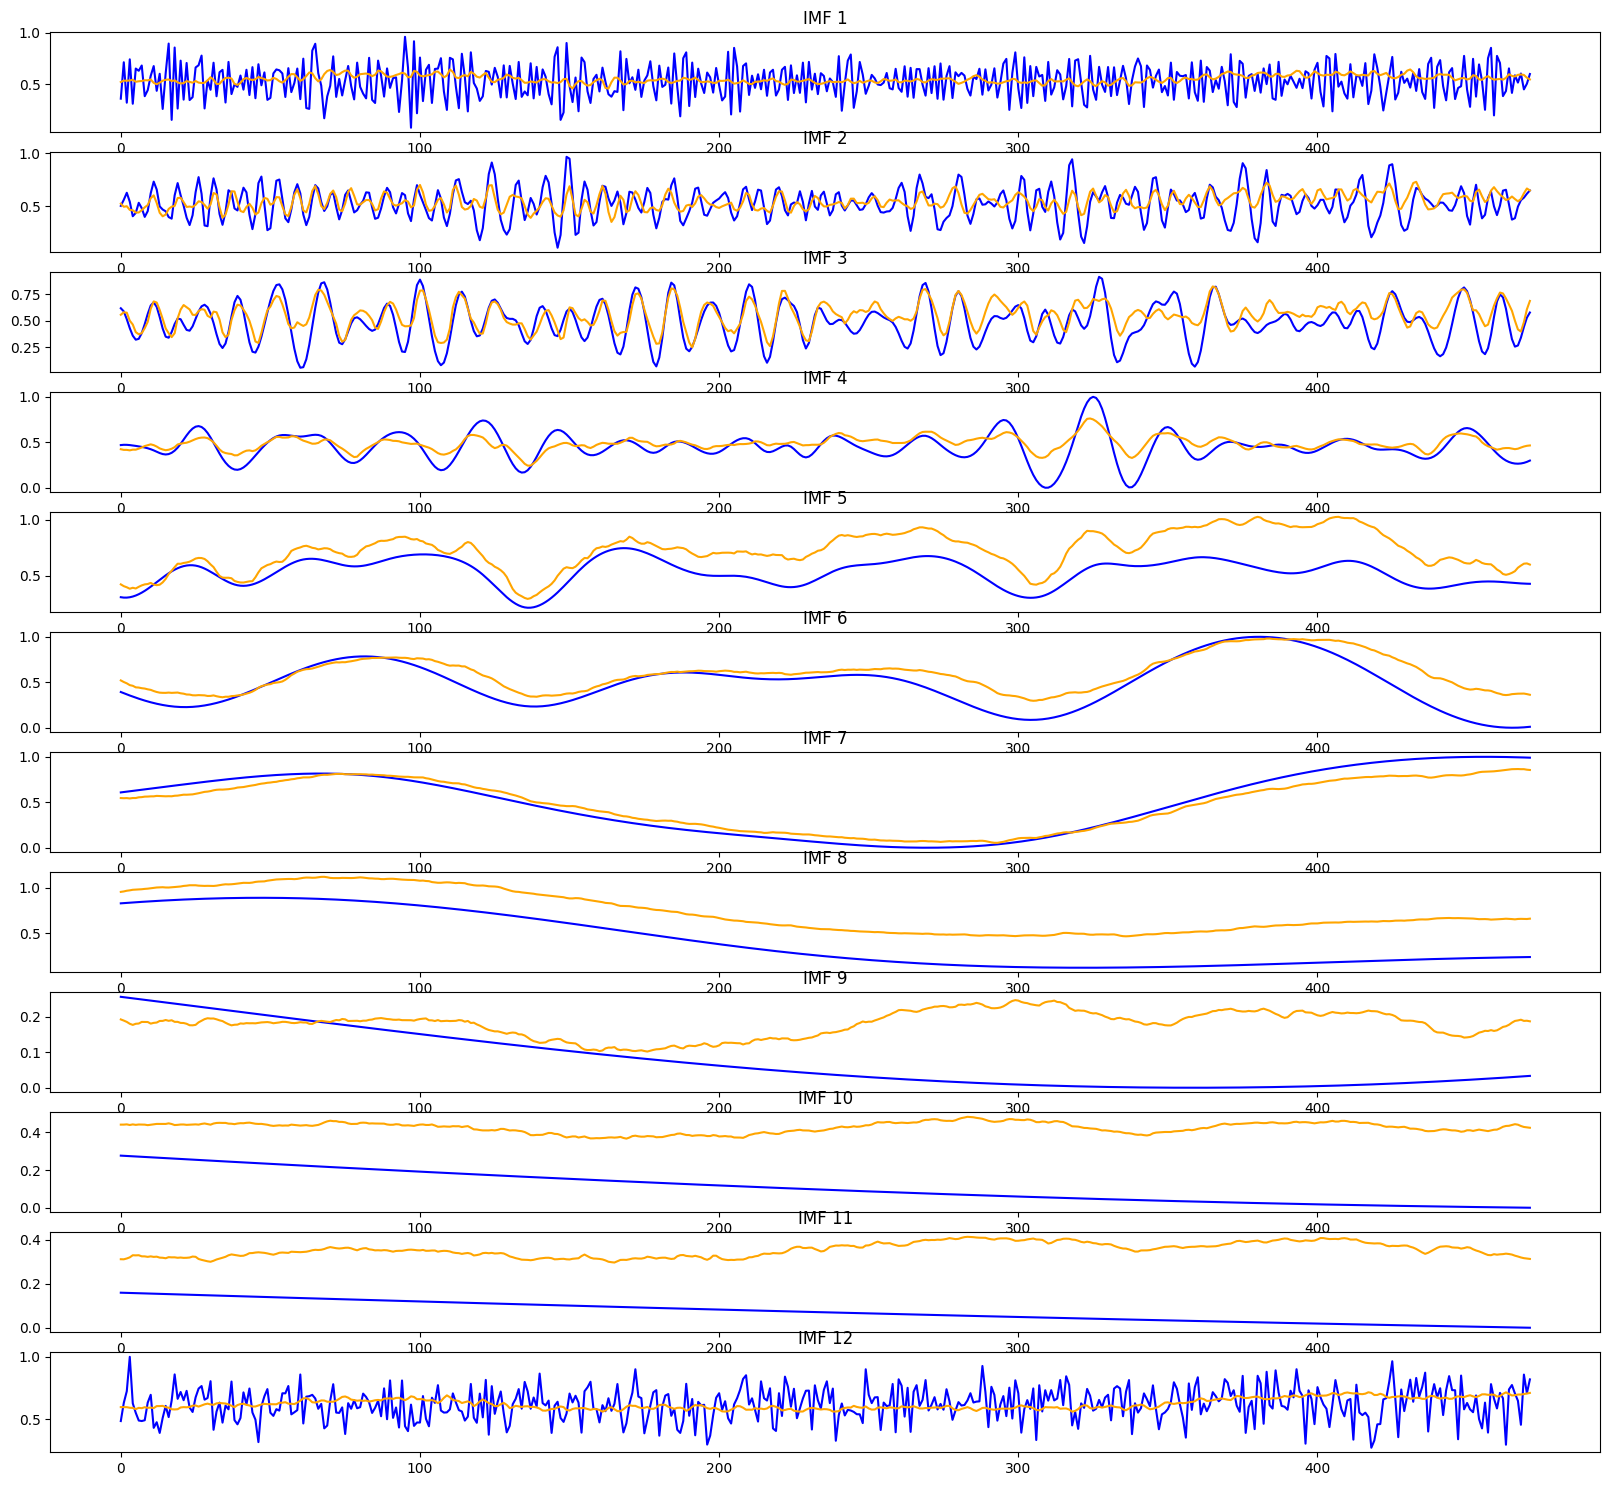

In [ ]:
plt.figure(figsize=[20,20])
for i in range(num_IMFs):
    plt.subplot(num_IMFs + 1, 1, i + 2)
    plt.plot(y_test[:,i], 'b')
    plt.plot(y_pred[:,i], 'orange')
    plt.title(f"IMF {i + 1}")

# Comparing the results/ overview:

**Results from this Notebook:**
The ensemlbe learning methods worked surprisingly well, in all cases even better with the previous EEMD. XGBoost perfored overall better than random forest. Of course the daily data showed way better results than the monthly data, but even with the monthly data, the results for the XGBoost models with EEMD where ok. The rolling forecast did not seem to work so well, might need further investigation.

